In [0]:
!git clone -b dev https://github.com/nyikovicsmate/thesis

Cloning into 'thesis'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 1567 (delta 98), reused 111 (delta 72), pack-reused 1419
Receiving objects: 100% (1567/1567), 163.36 MiB | 13.55 MiB/s, done.
Resolving deltas: 100% (587/587), done.


In [0]:
%cd thesis

/content/thesis


In [0]:
!pip3 install -q gdown
# bsd500_gray.zip
!gdown https://drive.google.com/uc?id=1O2tduoLX1DdP3VoLkAQfuv5ssFxf8LPc
!unzip -q bsd500_gray.zip
# # bsd500_color.zip
!gdown https://drive.google.com/uc?id=1buG1ziqMjy18gnpkuQjqk81XrLsGjT7p
!unzip -q bsd500_color.zip
# # set14_color.zip
!gdown https://drive.google.com/uc?id=1OiDs7jRm3NZCY6ghjyE12G5hVS0fG4EM
!unzip -q set14_color.zip

Downloading...
From: https://drive.google.com/uc?id=1O2tduoLX1DdP3VoLkAQfuv5ssFxf8LPc
To: /content/thesis/bsd500_gray.zip
11.3MB [00:00, 18.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1buG1ziqMjy18gnpkuQjqk81XrLsGjT7p
To: /content/thesis/bsd500_color.zip
29.4MB [00:01, 25.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OiDs7jRm3NZCY6ghjyE12G5hVS0fG4EM
To: /content/thesis/set14_color.zip
100% 831k/831k [00:00<00:00, 55.3MB/s]


In [0]:
from src.callbacks import *
from src.dataset import *
import numpy as np
import tensorflow as tf
import cv2

from src.networks.reinforced.reinforced_network import ReinforcedNetwork

In [0]:
batch_size = 50
seed = 1111
epochs = 1800
learning_rate = 1e-4

normalize = lambda x: np.asarray(x / 255.0, dtype=np.float32)
downsample = lambda x: np.array([cv2.resize(x_i, (x.shape[2]//2, x.shape[1]//2), interpolation=cv2.INTER_CUBIC) for x_i in x])

ds = HDFDataset("bsd500_70_70_gray.h5").batch(batch_size).shuffle(seed)
ds_hr = ds.map(normalize)
ds_lr = ds.map(normalize)

loss_func = tf.keras.losses.mse
cb = [TrainingCheckpointCallback(appendix="_half", save_freq=10),
       ExponentialDecayCallback(learning_rate, epochs/6, decay_rate=0.5)]

In [0]:
def custom_noise_func(images: np.ndarray) -> np.ndarray:
    """
    Adds noise to image.
    :param images: A batch of images, 4D array (batch, height, width, channels)
    :return: The noisy batch of input images.
    """
    fill_value = 0.5  # SET THE FILL VALUE TO 0.5
    try:
        # this will fail unless there is exactly 4 dimensions to unpack from
        batch, height, width, channels = images.shape
    except ValueError:
        raise TypeError(f"Image must be a 4D numpy array. Got shape {images.shape}")
    if channels == 1:
        for img in images:
            for h in range(height):
                if h % 2 == 0:
                    img[h][0::2] = [fill_value]
                else:
                    img[h][1::2] = [fill_value]
    elif channels == 3:
        for img in images:
            for h in range(height):
                if h % 2 == 0:
                    img[h][0::2] = [fill_value, fill_value, fill_value]
                else:
                    img[h][1::2] = [fill_value, fill_value, fill_value]
    else:
        raise ValueError(f"Unsupported number of image dimensions, got {channels}")
    return images

In [0]:
network = ReinforcedNetwork()
# bind the custom noise function
network.noise_func = custom_noise_func
network.train(ds_lr, ds_hr, None, epochs, learning_rate, cb)

[2020-05-19 21:48:08,768] INFO _train(): Epoch: 0 episode_r: 1.28 train_loss: 119.49
[2020-05-19 21:48:21,166] INFO _train(): Epoch: 1 episode_r: 1.61 train_loss: 109.99
[2020-05-19 21:48:33,717] INFO _train(): Epoch: 2 episode_r: 2.51 train_loss: 94.10
[2020-05-19 21:48:46,368] INFO _train(): Epoch: 3 episode_r: 3.39 train_loss: 76.05
[2020-05-19 21:48:59,102] INFO _train(): Epoch: 4 episode_r: 3.58 train_loss: 81.89
[2020-05-19 21:49:11,864] INFO _train(): Epoch: 5 episode_r: 3.72 train_loss: 67.90
[2020-05-19 21:49:24,629] INFO _train(): Epoch: 6 episode_r: 3.59 train_loss: 53.68
[2020-05-19 21:49:37,540] INFO _train(): Epoch: 7 episode_r: 4.18 train_loss: 48.63
[2020-05-19 21:49:50,503] INFO _train(): Epoch: 8 episode_r: 4.29 train_loss: 63.72
[2020-05-19 21:50:03,638] INFO _train(): Epoch: 9 episode_r: 4.07 train_loss: 40.21
[2020-05-19 21:50:03,639] INFO call(): Saving state after 10 epochs.
[2020-05-19 21:50:03,641] WARNING save_state(): Model directory /content/thesis/checkpoin

KeyboardInterrupt: ignored

[2020-05-20 00:56:16,483] INFO load_state(): Loaded state with: 
Train time: 02h:11m:59s
Epochs:     730
Loss:       13.8667
[2020-05-20 00:56:16,512] INFO _parse_predict_optionals(): Predicting using the default upsampling factor of 2.
[2020-05-20 00:56:17,346] INFO _predict(): Predicted images with shape: (14, 70, 70, 3)
   HR   ALIASED   NETWORK   


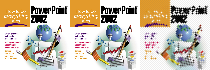

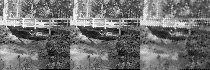

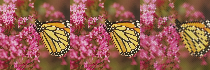

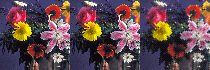

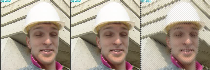

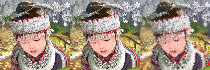

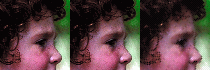

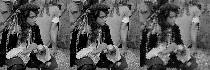

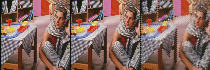

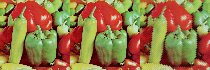

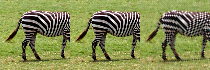

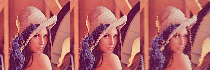

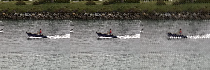

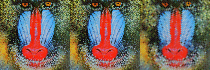

SSIM
max: [9] 0.87    min: [13] 0.76    avg: 0.81
TOTAL_VARIATION
max: [0] 3663.53    min: [6] 1268.80    avg: 2396.78
PSNR
max: [6] 28.27    min: [0] 18.23    avg: 22.37
MEAN_SQUARED_ERROR
max: [0] 73.69    min: [6] 7.30    avg: 33.22
MEAN_ABSOLUTE_ERROR
max: [0] 299.69    min: [6] 101.37    avg: 198.21


In [0]:
from google.colab.patches import cv2_imshow

ds_ev_lr = DirectoryDataset("set14_70_70_color").map(normalize)
ds_ev_hr = DirectoryDataset("set14_70_70_color").map(normalize)

# load best network state
network.load_state("_half")

with ds_ev_lr as x, ds_ev_hr as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

[2020-05-20 00:56:17,692] INFO _parse_predict_optionals(): Predicting using the default upsampling factor of 2.
[2020-05-20 00:56:18,219] INFO _predict(): Predicted images with shape: (10, 70, 70, 3)
   HR   ALIASED   NETWORK   


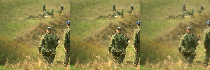

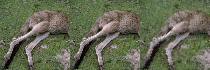

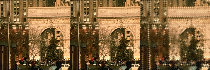

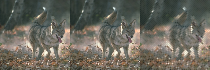

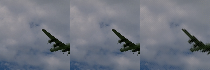

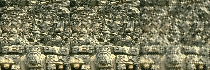

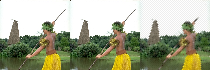

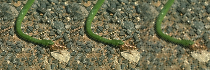

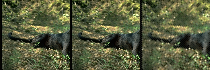

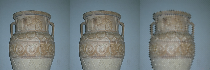

SSIM
max: [4] 0.96    min: [6] 0.71    avg: 0.81
TOTAL_VARIATION
max: [5] 3915.19    min: [4] 460.75    avg: 1902.79
PSNR
max: [4] 32.58    min: [5] 18.15    avg: 24.88
MEAN_SQUARED_ERROR
max: [5] 75.08    min: [4] 2.71    avg: 23.56
MEAN_ABSOLUTE_ERROR
max: [5] 343.88    min: [4] 33.60    avg: 161.07


In [0]:
# PREDICT WITH THE TRAINING DATASET - COLORED

ds = HDFDataset("bsd500_70_70_color.h5").batch(10)
ds_hr = ds.map(normalize)
ds_lr = ds.map(normalize)

with ds_lr as x, ds_hr as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

[2020-05-20 00:56:18,437] INFO _parse_predict_optionals(): Predicting using the default upsampling factor of 2.
[2020-05-20 00:56:18,518] INFO _predict(): Predicted images with shape: (10, 70, 70, 1)
   HR   ALIASED   NETWORK   


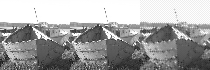

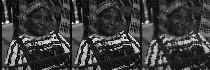

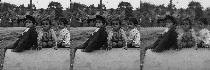

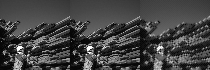

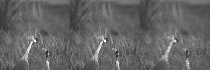

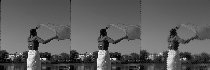

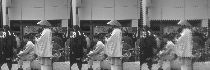

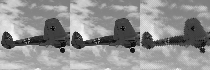

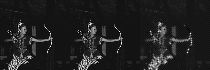

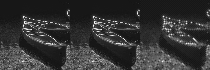

SSIM
max: [5] 0.92    min: [0] 0.73    avg: 0.83
TOTAL_VARIATION
max: [1] 883.62    min: [4] 286.49    avg: 563.86
PSNR
max: [4] 29.94    min: [3] 21.13    avg: 24.47
MEAN_SQUARED_ERROR
max: [3] 37.79    min: [4] 4.97    avg: 20.68
MEAN_ABSOLUTE_ERROR
max: [1] 208.61    min: [4] 68.09    avg: 139.77


In [0]:
# PREDICT WITH THE TRAINING DATASET - GRAY

ds = HDFDataset("bsd500_70_70_gray.h5").batch(10)
ds_hr = ds.map(normalize)
ds_lr = ds.map(normalize)

with ds_lr as x, ds_hr as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

In [0]:
!zip -r reinforcednetwork_half.zip ./checkpoints/reinforcednetwork_half

  adding: checkpoints/reinforcednetwork_half/ (stored 0%)
  adding: checkpoints/reinforcednetwork_half/checkpoint (deflated 37%)
  adding: checkpoints/reinforcednetwork_half/weights.data-00000-of-00002 (deflated 79%)
  adding: checkpoints/reinforcednetwork_half/weights.data-00001-of-00002 (deflated 8%)
  adding: checkpoints/reinforcednetwork_half/weights.index (deflated 68%)
  adding: checkpoints/reinforcednetwork_half/state.dat (deflated 13%)


In [0]:
from google.colab.files import download

download("reinforcednetwork_half.zip")